<a href="https://colab.research.google.com/github/profRCC/Softex/blob/master/Previs%C3%A3oSerieTemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Previsão de Séries Temporais**
* Uma série temporal é um dataset onde os dados são organizados no tempo
* Várias aplicações do mundo real produzem dados com essa natureza
  * série de vendas de um produto
  * série de número de contaminações de uma doença
  * série de temperaturas medidas em uma cidade
  * série de preços de um ativo financeiro
* Uma característica desse tipo de dataset é a dependência temporal das instâncias
  * pode ajudar na previsão
*Dataset usado:
  * [Tempeturas mínimas diárias em Melbourne, Austrália](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1. Importar bibliotecas necessárias

In [ ]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2. Lendo dados

In [ ]:
# lendo csv e armazenando em um dataframe
dados = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Softex/Semana5/datasets/temperatures/temperatures.csv')
dados.Date = pd.to_datetime(dados.Date,format='%Y-%m-%d')
dados.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


## 3. Análise Preliminar dos Dados



In [ ]:
dados.shape

(3650, 2)

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

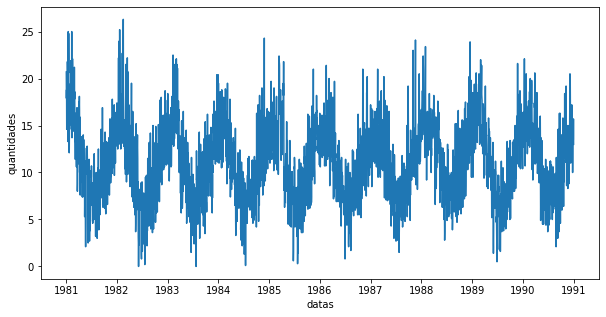

In [ ]:
#plotando série temporal
plt.plot(dados.Date,dados.Temp)
plt.xlabel('datas')
plt.ylabel('quantidades')
plt.show()


In [ ]:
## criar coluna com mes do ano e ano
dados['mes'] = dados.Date.dt.month
dados['ano'] = dados.Date.dt.year

In [ ]:
## agrupa dados de cada mes pelo ano
mensal = dados.groupby(['ano','mes'],as_index=True)['Temp'].mean().reset_index().rename(columns={0:'Temp'})
mensal.head()

,ano,mes,Temp
0,1981,1,17.712903
1,1981,2,17.678571
2,1981,3,13.500000
3,1981,4,12.356667
4,1981,5,9.490323


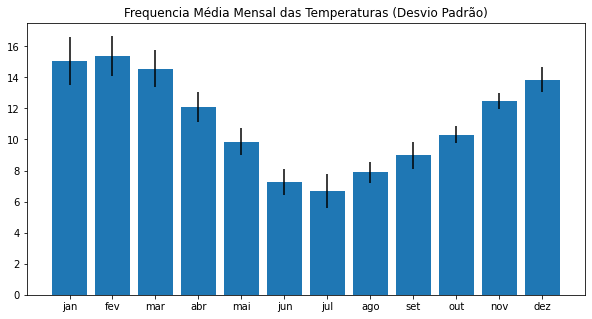

In [ ]:
# plotar vendas medias do produto por mes do ano
indice = ['jan','fev','mar','abr','mai','jun','jul','ago','set','out','nov','dez']
stats = mensal.groupby(['mes'],as_index=False)['Temp'].agg(['mean','std'])
plt.bar(indice,stats['mean'],yerr=stats['std'])
plt.title('Frequencia Média Mensal das Temperaturas (Desvio Padrão)')
plt.show()

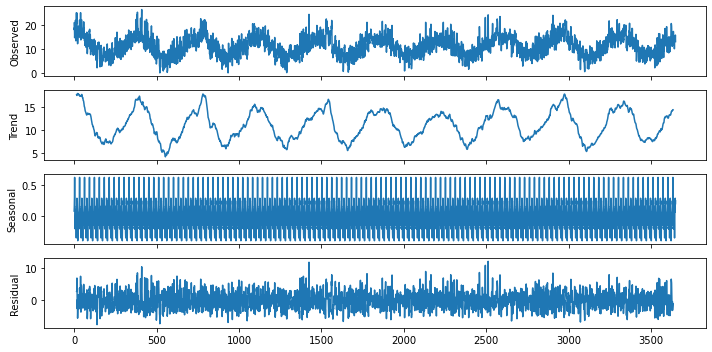

In [ ]:
#decomposicao da serie temporal em tendência, sazonalidade e ruído
decomposition = seasonal_decompose(dados.Temp,model='additive',freq=30)
decomposition.plot()
plt.show()

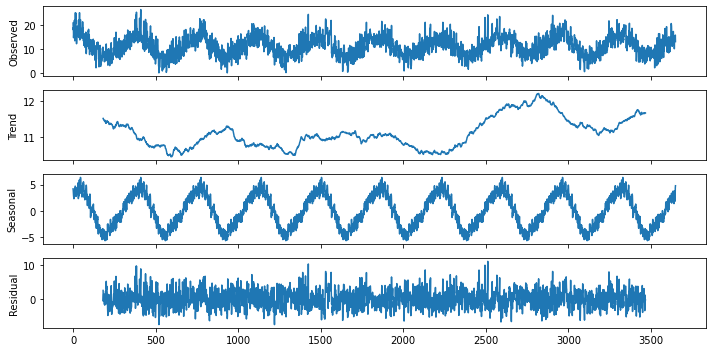

In [ ]:
#decomposicao da serie temporal
decomposition = seasonal_decompose(dados.Temp,model='additive',freq=365)
decomposition.plot()
plt.show()

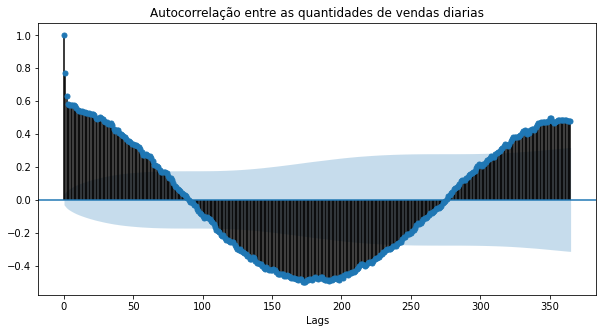

In [ ]:
# Função de autocorrelação entre as observações
plot_acf(dados.Temp,lags=365)
plt.title('Autocorrelação entre as quantidades de vendas diarias')
plt.xlabel('Lags')
plt.show()

## 4. Organização dos dados para modelagem

In [ ]:
def organizarDados(sequence,n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
X,y = organizarDados(dados.Temp,30)

In [ ]:
X[:10]

array([[20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2,
        13.3, 16.7, 21.5, 25. , 20.7, 20.6, 24.8, 17.7, 15.5, 18.2, 12.1,
        14.4, 16. , 16.5, 18.7, 19.4, 17.2, 15.5, 15.1],
       [17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3,
        16.7, 21.5, 25. , 20.7, 20.6, 24.8, 17.7, 15.5, 18.2, 12.1, 14.4,
        16. , 16.5, 18.7, 19.4, 17.2, 15.5, 15.1, 15.4],
       [18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3, 16.7,
        21.5, 25. , 20.7, 20.6, 24.8, 17.7, 15.5, 18.2, 12.1, 14.4, 16. ,
        16.5, 18.7, 19.4, 17.2, 15.5, 15.1, 15.4, 15.3],
       [14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3, 16.7, 21.5,
        25. , 20.7, 20.6, 24.8, 17.7, 15.5, 18.2, 12.1, 14.4, 16. , 16.5,
        18.7, 19.4, 17.2, 15.5, 15.1, 15.4, 15.3, 18.8],
       [15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3, 16.7, 21.5, 25. ,
        20.7, 20.6, 24.8, 17.7, 15.5, 18.2, 12.1, 14.4, 16. , 16.5, 18.7,
        19.4, 17.2, 15.5, 15.1, 

In [ ]:
y[:10]

array([15.4, 15.3, 18.8, 21.9, 19.9, 16.6, 16.8, 14.6, 17.1, 25. ])

In [ ]:
# dividindo dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

## 5. Treinando os modelos e fazendo previsão


In [ ]:
#definindo modelo de regressão linear
linear = LinearRegression()
linear.fit(X_train,y_train)
pred_linear = linear.predict(X_test)

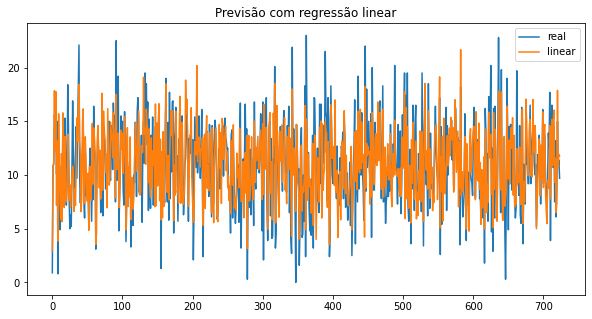

In [ ]:
#plotando resultados da MLP
plt.plot(y_test,label='real')
plt.plot(pred_linear,label='linear')
plt.legend()
plt.title('Previsão com regressão linear')
plt.show()

In [ ]:
#definindo modelo de árvore de decisão
arvore = DecisionTreeRegressor()
arvore.fit(X_train,y_train)
pred_arvore = arvore.predict(X_test)

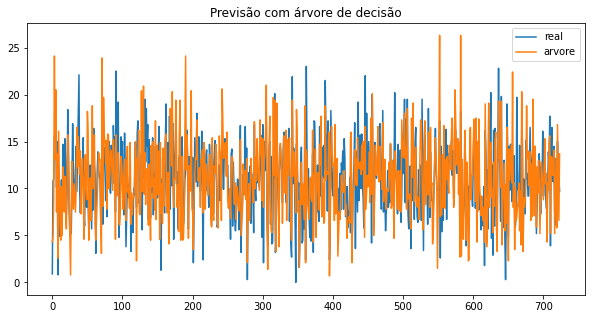

In [ ]:
#plotando resultados da árvore de decisão
plt.plot(y_test,label='real')
plt.plot(pred_arvore,label='arvore')
plt.legend()
plt.title('Previsão com árvore de decisão')
plt.show()

In [ ]:
#definindo modelo de random forest
floresta = RandomForestRegressor(n_estimators=100)
floresta.fit(X_train,y_train)
pred_floresta = floresta.predict(X_test)

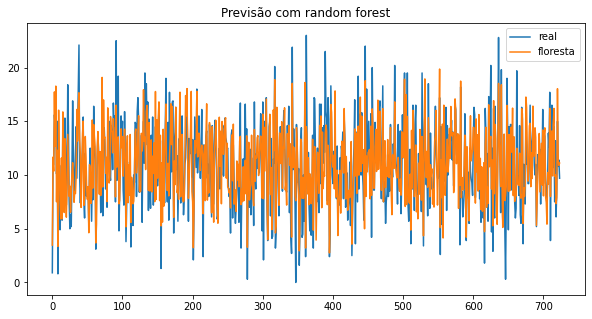

In [ ]:
#plotando resultados da random forest
plt.plot(y_test,label='real')
plt.plot(pred_floresta,label='floresta')
plt.legend()
plt.title('Previsão com random forest')
plt.show()

In [ ]:
#define modelo MLP
mlp = MLPRegressor(hidden_layer_sizes=(100),activation='logistic',max_iter=1000)
mlp.fit(X_train,y_train)
pred_mlp = mlp.predict(X_test)

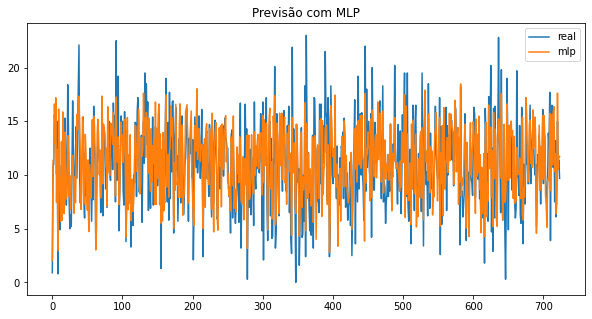

In [ ]:
#plotando resultados da MLP
plt.plot(y_test,label='real')
plt.plot(pred_mlp,label='mlp')
plt.legend()
plt.title('Previsão com MLP')
plt.show()

In [ ]:
print('MAE')
print('\tRegressão Linear:',round(mean_absolute_error(y_test,pred_linear),2))
print('\tArvore de Decisão:',round(mean_absolute_error(y_test,pred_arvore),2))
print('\tRandom Forest:',round(mean_absolute_error(y_test,pred_floresta),2))
print('\tMLP:',round(mean_absolute_error(y_test,pred_mlp),2))

MAE
	Regressão Linear: 1.91
	Arvore de Decisão: 2.67
	Random Forest: 1.92
	MLP: 1.98


In [ ]:
print('MSE')
print('\tRegressão Linear:',round(mean_squared_error(y_test,pred_linear),2))
print('\tArvore de Decisão:',round(mean_squared_error(y_test,pred_arvore),2))
print('\tRandom Forest:',round(mean_squared_error(y_test,pred_floresta),2))
print('\tMLP:',round(mean_squared_error(y_test,pred_mlp),2))

MSE
	Regressão Linear: 5.88
	Arvore de Decisão: 11.77
	Random Forest: 6.05
	MLP: 6.32


In [ ]:
print('RMSE')
print('\tRegressão Linear:',round(mean_squared_error(y_test,pred_linear)**(1/2),2))
print('\tArvore de Decisão:',round(mean_squared_error(y_test,pred_arvore)**(1/2),2))
print('\tRandom Forest:',round(mean_squared_error(y_test,pred_floresta)**(1/2),2))
print('\tMLP:',round(mean_squared_error(y_test,pred_mlp)**(1/2),2))

RMSE
	Regressão Linear: 2.43
	Arvore de Decisão: 3.43
	Random Forest: 2.46
	MLP: 2.51


In [ ]:
def mean_absolute_percentage_error(y_test,y_pred):
  y_test=y_test
  erro = 0
  for i in range(len(y_test)):
    erro += abs(y_test[i]-y_pred[i])/y_test[i]
  return erro/len(y_test)

In [ ]:
print('MAPE')
print('\tRegressão Linear:',round(mean_absolute_percentage_error(y_test,pred_linear)**(1/2),2))
print('\tArvore de Decisão:',round(mean_absolute_percentage_error(y_test,pred_arvore)**(1/2),2))
print('\tRandom Forest:',round(mean_absolute_percentage_error(y_test,pred_floresta)**(1/2),2))
print('\tMLP:',round(mean_absolute_percentage_error(y_test,pred_mlp)**(1/2),2))

MAPE
	Regressão Linear: inf
	Arvore de Decisão: inf
	Random Forest: inf
	MLP: inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
